## library

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import torchvision.datasets as datasets
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.csgraph import connected_components
from sklearn.cluster import KMeans

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## data

In [ ]:
dataset = datasets.MNIST('./mnist', train=True, download=True,
                         transform = T.Compose([T.ToTensor(),
                                                T.Normalize([0.5,],[0.5,]),
                                                T.Lambda(lambda x: torch.flatten(x))]))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

testset = datasets.MNIST('./mnist', train=False, download=True,
                         transform = T.Compose([T.ToTensor(),
                                                T.Normalize([0.5,],[0.5,]),
                                                T.Lambda(lambda x: torch.flatten(x))]))
testloader = DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 72603828.67it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21988690.11it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21490804.73it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22952444.30it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



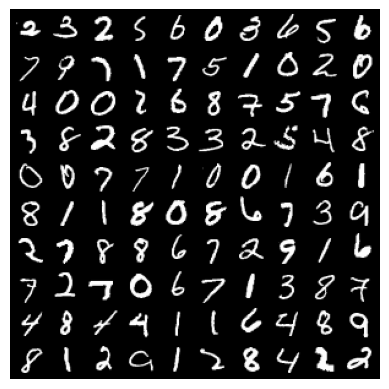

In [ ]:
img, _ = next(iter(dataloader))
img = img.reshape(-1,1,28,28)
grid = make_grid(img[:100], nrow=10, padding=2, normalize=True)

plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis('off')
plt.show()

## Auto Encoder

In [ ]:
# Affine
class BaseEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super(BaseEncoder, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(hidden_dim[i],
                      hidden_dim[i+1]) for i in range(len(hidden_dim)-1) ])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = F.sigmoid(x)
        return x

class BaseDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super(BaseDecoder, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(hidden_dim[i],
                      hidden_dim[i+1]) for i in range(len(hidden_dim)-1) ])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = F.sigmoid(x)
        return x

class AE(nn.Module):
    def __init__(self, hidden_dim):
        super(AE, self).__init__()
        self.encoder = BaseEncoder(hidden_dim)
        self.decoder = BaseDecoder(hidden_dim[::-1])
    def forward(self, img):
        h = self.encoder(img)
        x_rec = self.decoder(h)
        return x_rec, h

In [ ]:
img, _ = next(iter(dataloader))
ae = AE([784, 1000, 500, 500])
x_rec, h = ae(img)
print(x_rec.size())
print(h.size())

torch.Size([128, 784])
torch.Size([128, 500])


## DEN (separate analysis)

In [ ]:

class DEN(nn.Module):
    def __init__(self, hidden_dim, t, lamb):
        super(DEN, self).__init__()
        self.encoder = BaseEncoder(hidden_dim)
        self.decoder = BaseDecoder(hidden_dim[::-1])
        self.t = t
        self.lamb = lamb
        self.training_mode = True

    def compute_locality_preserving(self, x, z):
        embed = torch.sum((z.unsqueeze(1) - z)**2, 2)
        kernel = torch.exp(-torch.mean((x.unsqueeze(1) - x)**2, 2)/self.t[0])
        energy = kernel * embed
        idx = torch.mean((x.unsqueeze(1) - x)**2, 2) < self.t[1]
        return torch.sum(energy[idx], dim=0)

    def compute_group_sparsity(self, z):
        group = torch.sum((z.unsqueeze(1) - z)**2, 2) < self.t[2]
        n_clus, pred = connected_components(group.detach().cpu(), directed=False, return_labels=True)
        E_s = 0
        for c in range(n_clus):
            f_g = group[pred==c]
            E_s += self.lamb * f_g.size(0)**0.5 * torch.sum(f_g)
        return E_s * 1e-6

    def forward(self, img):
        z = self.encoder(img)
        img_re = self.decoder(z)
        if self.training_mode:
            E_g = self.compute_locality_preserving(img, z)
            E_s = self.compute_group_sparsity(z)
            E_r = F.mse_loss(img_re, img)
            return E_r, E_g, E_s, img_re
        else:
            return z, img_re

In [ ]:
# setting

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DEN([784, 1000, 500, 500],t=[1e-0, 0.4, 0.004], lamb=1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0008, momentum=0.9)

In [ ]:
# training

n_epochs = 40

for epoch in range(n_epochs):
    mean_Er = 0
    mean_Eg = 0
    mean_Es = 0
    model.training_mode = True
    loss_w=[0.0, 0.0] if epoch < 20 else [2.0, 2.0]
    for i, (img,_) in enumerate(dataloader):
        img = img.to(device)

        optimizer.zero_grad()
        E_r, E_g, E_s, img_re = model(img)
        loss = E_r + loss_w[0]*E_g + loss_w[1]*E_s
        loss.backward()
        optimizer.step()

        mean_Er += E_r.item()
        mean_Eg += E_g.item()
        mean_Es += E_s.item()

    print('Epoch : %3d  Er : %.6f  Eg : %.6f  Es : %.6f'%(
        epoch+1, mean_Er/len(dataloader), mean_Eg/len(dataloader), mean_Es/len(dataloader)
    ))

Epoch :   1  Er : 1.702016  Eg : 2.381941  Es : 0.184870
Epoch :   2  Er : 1.387362  Eg : 2.385194  Es : 0.184867
Epoch :   3  Er : 1.214685  Eg : 2.381876  Es : 0.184871
Epoch :   4  Er : 1.121445  Eg : 2.385099  Es : 0.184873
Epoch :   5  Er : 1.067646  Eg : 2.381632  Es : 0.184865
Epoch :   6  Er : 1.034194  Eg : 2.378479  Es : 0.184874
Epoch :   7  Er : 1.012009  Eg : 2.382014  Es : 0.184869
Epoch :   8  Er : 0.996499  Eg : 2.385541  Es : 0.184870
Epoch :   9  Er : 0.985199  Eg : 2.381012  Es : 0.184867
Epoch :  10  Er : 0.976676  Eg : 2.385115  Es : 0.184868
Epoch :  11  Er : 0.970058  Eg : 2.382212  Es : 0.184869
Epoch :  12  Er : 0.964806  Eg : 2.380057  Es : 0.184878
Epoch :  13  Er : 0.960552  Eg : 2.382009  Es : 0.184871
Epoch :  14  Er : 0.957049  Eg : 2.378976  Es : 0.184872
Epoch :  15  Er : 0.954119  Eg : 2.378421  Es : 0.184874
Epoch :  16  Er : 0.951643  Eg : 2.381561  Es : 0.184875
Epoch :  17  Er : 0.949524  Eg : 2.377959  Es : 0.184877
Epoch :  18  Er : 0.947694  Eg 

In [ ]:
# save model

torch.save(model.state_dict(),
           '/content/drive/MyDrive/Colab Notebooks/코드 이론/Clustering/DAE_MNIST_40')

In [ ]:
# load model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DEN([784, 1000, 500, 500],t=[1e-0, 0.4, 0.004],lamb=1).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/코드 이론/Clustering/DAE_MNIST_10'))

<All keys matched successfully>

In [ ]:
# prediction
preds = None
for img, label in testloader:
    img = img.to(device)
    model.training_mode = False
    with torch.no_grad():
        z, img_re = model(img)
    if preds is None:
        preds = z.detach().cpu().numpy()
    else:
        preds = np.concatenate([preds, z.detach().cpu().numpy()], axis=0)

kmeans = KMeans(n_clusters=10, n_init=20)
preds = kmeans.fit_predict(preds)

In [ ]:
def plot_cluster(cluster, n_images=100):
    idx = np.where(preds==cluster)

    images = [testset[id][0].numpy() for id in idx[0]]
    img = torch.tensor(np.array(images)).view(-1,1,28,28)
    grid = make_grid(img[:n_images], nrow=10, padding=2, normalize=True)

    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.axis('off')
    plt.show()

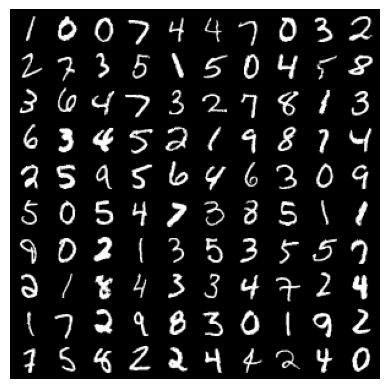

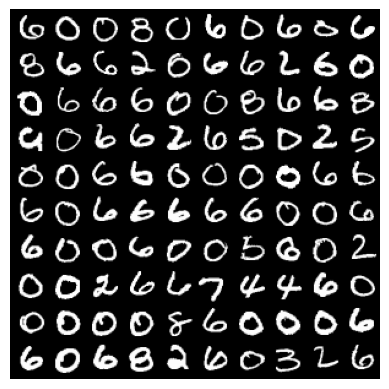

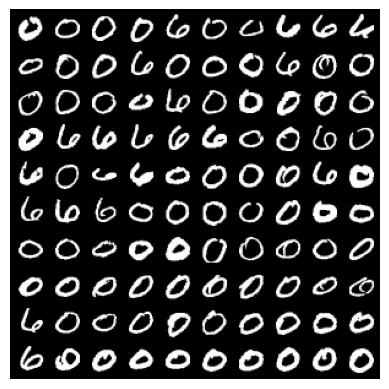

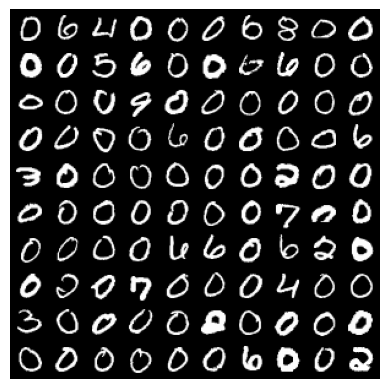

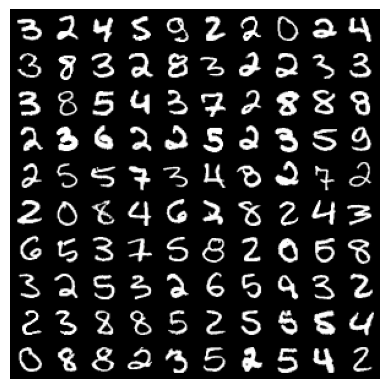

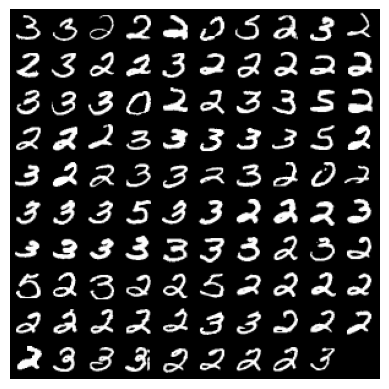

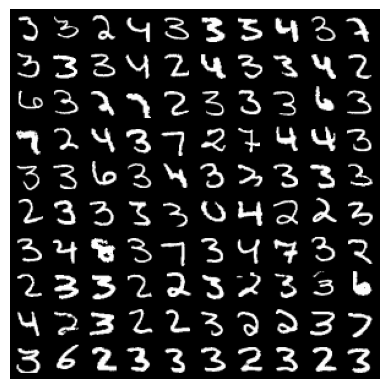

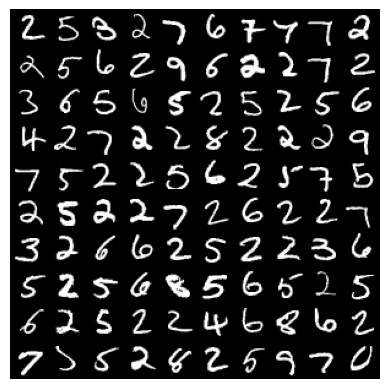

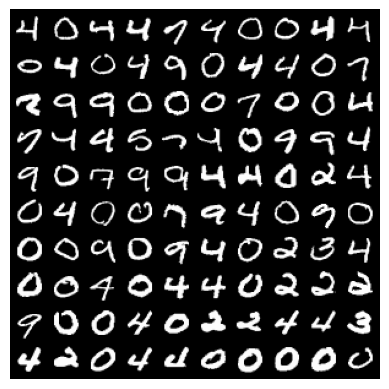

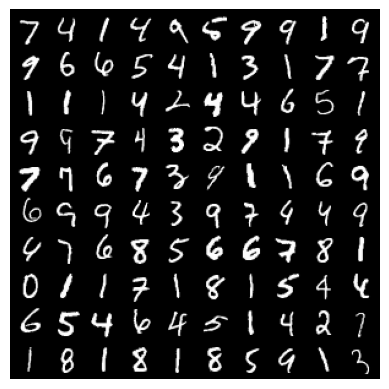

In [ ]:
for i in range(10):
    plot_cluster(i)

## DEC (jointly analysis)

In [ ]:
class DEC(nn.Module):
    def __init__(self, hidden_dim, n_clusters, alpha):
        super(DEC, self).__init__()
        self.encoder = BaseEncoder(hidden_dim)
        self.decoder = BaseDecoder(hidden_dim[::-1])
        self.cluster_centroids = nn.Parameter(torch.rand((n_clusters,
                                                          hidden_dim[-1])))
        nn.init.xavier_uniform_(self.cluster_centroids)
        self.alpha = alpha
        self.training_mode = True

    def compute_soft_assignment(self, z):
        norm = torch.sum((z.unsqueeze(1) - self.cluster_centroids)**2, 2)
        score = (1+norm/self.alpha) ** (-(self.alpha+1)/2)
        return score / torch.sum(score, dim=1, keepdim=True)

    def compute_target_distribution(self, soft):
        square = soft ** 2 / torch.sum(soft, 0)
        normal = square / torch.sum(square, dim=1, keepdim=True)
        return normal

    def forward(self, img):
        z = self.encoder(img)
        img_re = self.decoder(z)

        if self.training_mode:
            soft_assignment = self.compute_soft_assignment(z)
            target_distribution = self.compute_target_distribution(soft_assignment)

            loss_recons = F.mse_loss(img, img_re)
            loss_kldiv = F.kl_div(soft_assignment.log(), target_distribution,
                                  reduction='sum') * 1e+4
            return loss_recons,loss_kldiv, img_re

        else:
            return z, img_re

In [ ]:
# setting

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DEC([784, 1000, 500, 500], 10, 1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [ ]:
# training

n_epochs = 40


for epoch in range(n_epochs):
    mean_recons = 0
    mean_kldiv = 0
    model.training_mode = True
    loss_w = 1 if epoch <20 else 0.3
    for i, (img,_) in enumerate(dataloader):
        img = img.to(device)

        optimizer.zero_grad()
        loss_recons, loss_kldiv, img_re = model(img)
        loss = loss_w * loss_recons + (1-loss_w)*loss_kldiv
        loss.backward()
        optimizer.step()

        mean_recons += loss_recons.item()
        mean_kldiv += loss_kldiv.item()

    print('Epoch : %3d  Recons : %.6f  KL : %.6f'%(
        epoch+1, mean_recons/len(dataloader), mean_kldiv/len(dataloader)
    ))

Epoch :   1  Recons : 1.256516  KL : 0.011700
Epoch :   2  Recons : 0.980701  KL : 0.011717
Epoch :   3  Recons : 0.951746  KL : 0.012356
Epoch :   4  Recons : 0.942051  KL : 0.012343
Epoch :   5  Recons : 0.937355  KL : 0.012480
Epoch :   6  Recons : 0.934633  KL : 0.012788
Epoch :   7  Recons : 0.932869  KL : 0.012027
Epoch :   8  Recons : 0.931644  KL : 0.011495
Epoch :   9  Recons : 0.930745  KL : 0.012271
Epoch :  10  Recons : 0.930059  KL : 0.011548
Epoch :  11  Recons : 0.929522  KL : 0.011041
Epoch :  12  Recons : 0.929091  KL : 0.011239
Epoch :  13  Recons : 0.928737  KL : 0.011853
Epoch :  14  Recons : 0.928443  KL : 0.011338
Epoch :  15  Recons : 0.928188  KL : 0.012085
Epoch :  16  Recons : 0.927975  KL : 0.013025
Epoch :  17  Recons : 0.927788  KL : 0.012122
Epoch :  18  Recons : 0.927625  KL : 0.011664
Epoch :  19  Recons : 0.927484  KL : 0.010263
Epoch :  20  Recons : 0.927356  KL : 0.011816
Epoch :  21  Recons : 0.927279  KL : 0.010776
Epoch :  22  Recons : 0.927246  KL

In [ ]:
# save model

torch.save(model.state_dict(),
           '/content/drive/MyDrive/Colab Notebooks/코드 이론/Clustering/DEC_MNIST_40')

In [ ]:
# load model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DEC([784, 1000, 500, 500], 10, 1).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/코드 이론/Clustering/DEC_MNIST_10'))

<All keys matched successfully>

In [ ]:
# prediction
preds = None
for img, label in testloader:
    img = img.to(device)
    model.training_mode = False
    with torch.no_grad():
        z, img_re = model(img)
        distance = torch.sum((z.unsqueeze(1) - model.cluster_centroids)**2, 2)
    _, pred = distance.min(dim=1)
    if preds is None:
        preds = pred.detach().cpu()
    else:
        preds = np.concatenate([preds,pred.detach().cpu()], axis=0)

In [ ]:
np.unique(preds)

array([8])

In [ ]:
for i in range(10):
    plot_cluster(i)

RuntimeError: ignored